In [4]:

import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [5]:
tensor_transform = transforms.ToTensor()
# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = 32,
                                     shuffle = True)


100%|██████████| 9912422/9912422 [00:00<00:00, 185639003.59it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 54762971.89it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43073832.03it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17178114.31it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
test_dataset = datasets.MNIST(root = "./data",
                         train = False,
                         download = True,
                         transform = tensor_transform)

test_loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = 32,
                                     shuffle = True)

print(len(test_dataset))
print(len(dataset))

10000
60000


28*28=784 -> 128 -> 64 -> 36 ->18 -> 9 -> 18 -> 36 -> 64 ->128 ->784

In [7]:
import torch

class AutoEncoder(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # part 1 to build an encoder

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28*28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )

        # part 2: build a decoder

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded




In [8]:
# Model Initialization
model = AutoEncoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=model.to(device)
# Validation using MSE Loss function
# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Train the autoencoder model
def train_model(model,num_epochs,train_loader,optimizer):
  for epoch in range(num_epochs):
      for batch in train_loader:
          images, _ = batch[0].to(device),batch[1].to(device)
          images = images.view(images.size(0), -1)

          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, images)

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

In [10]:
train_model(model,10,train_loader,optimizer)

Epoch [1/10], Loss: 0.04124981909990311
Epoch [2/10], Loss: 0.034090425819158554
Epoch [3/10], Loss: 0.03168840333819389
Epoch [4/10], Loss: 0.025692204013466835
Epoch [5/10], Loss: 0.027036335319280624
Epoch [6/10], Loss: 0.024680983275175095
Epoch [7/10], Loss: 0.02815299853682518
Epoch [8/10], Loss: 0.02452193759381771
Epoch [9/10], Loss: 0.023847199976444244
Epoch [10/10], Loss: 0.027460560202598572


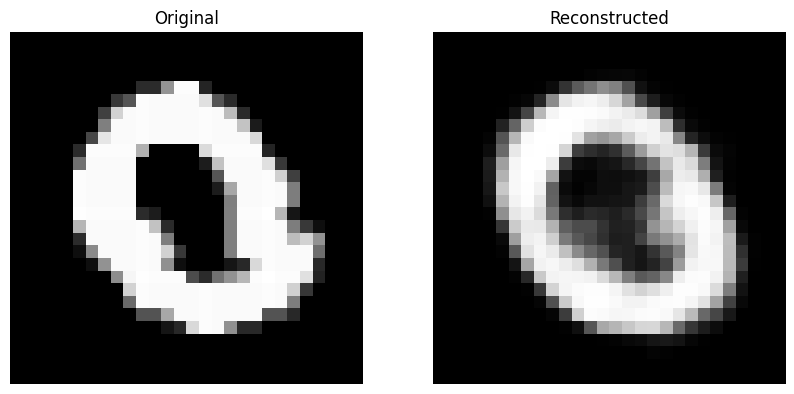

Average SSIM: 0.7569865334389001


In [11]:
import torch
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt

def evaluate_autoencoder(model, test_loader):
    model.eval()  # Set model to evaluation mode
    device = next(model.parameters()).device  # Get the device where the model is located

    ssim_scores = []
    original_images = []
    reconstructed_images = []

    with torch.no_grad():
        for batch in test_loader:
            images, _ = batch
            images = images.to(device)  # Move images to the same device as the model
            images = images.view(images.size(0), -1)
            reconstructed = model(images)
            for i in range(len(images)):
                original_image_np = images[i].view(28, 28).cpu().numpy()  # Move to CPU and convert to NumPy array
                reconstructed_image_np = reconstructed[i].view(28, 28).cpu().numpy()  # Move to CPU and convert to NumPy array
                original_images.append(original_image_np)
                reconstructed_images.append(reconstructed_image_np)
                ssim_score = ssim(original_image_np, reconstructed_image_np)
                ssim_scores.append(ssim_score)

    # Calculate average SSIM
    average_ssim = np.mean(ssim_scores)

    # Randomly select an index
    idx = np.random.randint(len(original_images))

    # Plot original and reconstructed images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_images[idx], cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(reconstructed_images[idx], cmap='gray')
    axes[1].set_title('Reconstructed')
    axes[1].axis('off')

    plt.show()

    return average_ssim

average_ssim = evaluate_autoencoder(model, test_loader)
print(f'Average SSIM: {average_ssim}')


In [2]:
# Function to add Gaussian noise to images
def add_noise(images, sigma):
    noise = torch.randn_like(images) * sigma
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0, 1)  # Ensure pixel values are between 0 and 1


Sigma: 0.1
Epoch [1/10], Loss: 0.01888195611536503
Epoch [2/10], Loss: 0.01933649554848671
Epoch [3/10], Loss: 0.022875158116221428
Epoch [4/10], Loss: 0.015294929035007954
Epoch [5/10], Loss: 0.01659906655550003
Epoch [6/10], Loss: 0.017561253160238266
Epoch [7/10], Loss: 0.017130207270383835
Epoch [8/10], Loss: 0.01927335187792778
Epoch [9/10], Loss: 0.016470082104206085
Epoch [10/10], Loss: 0.018664564937353134


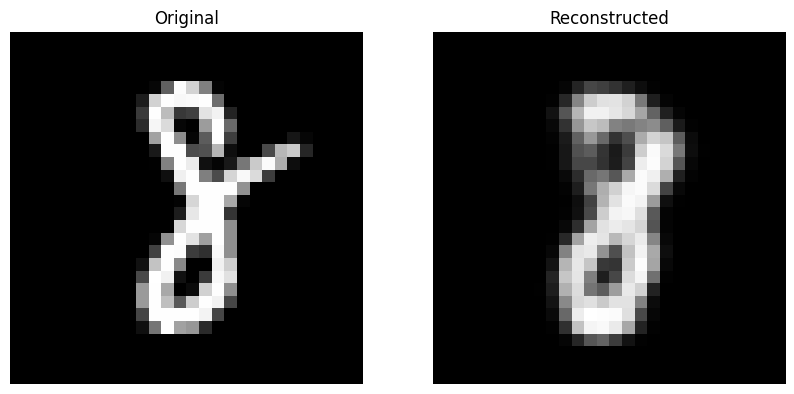

Sigma: 0.5
Epoch [1/10], Loss: 0.02363346703350544
Epoch [2/10], Loss: 0.024020960554480553
Epoch [3/10], Loss: 0.021461982280015945
Epoch [4/10], Loss: 0.024437636137008667
Epoch [5/10], Loss: 0.02393343858420849
Epoch [6/10], Loss: 0.022480498999357224
Epoch [7/10], Loss: 0.025030504912137985
Epoch [8/10], Loss: 0.02369036339223385
Epoch [9/10], Loss: 0.025002868846058846
Epoch [10/10], Loss: 0.021112997084856033


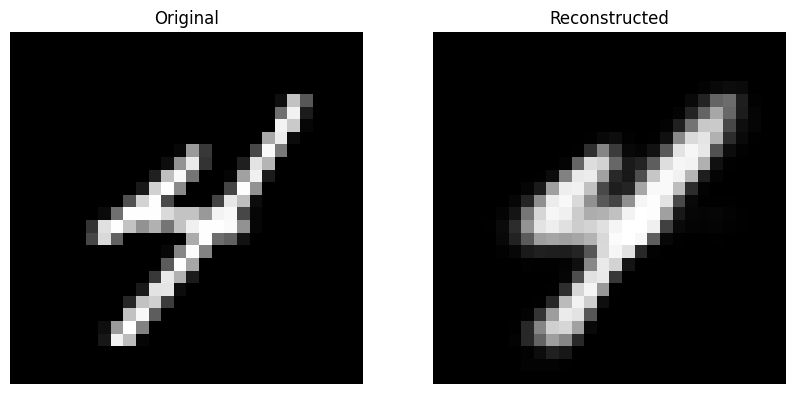

Sigma: 1.0
Epoch [1/10], Loss: 0.035290636122226715
Epoch [2/10], Loss: 0.03741827607154846
Epoch [3/10], Loss: 0.034943532198667526
Epoch [4/10], Loss: 0.03821893781423569
Epoch [5/10], Loss: 0.03201305493712425
Epoch [6/10], Loss: 0.03311406075954437
Epoch [7/10], Loss: 0.027611322700977325
Epoch [8/10], Loss: 0.03276802971959114
Epoch [9/10], Loss: 0.03614812344312668
Epoch [10/10], Loss: 0.03227502480149269


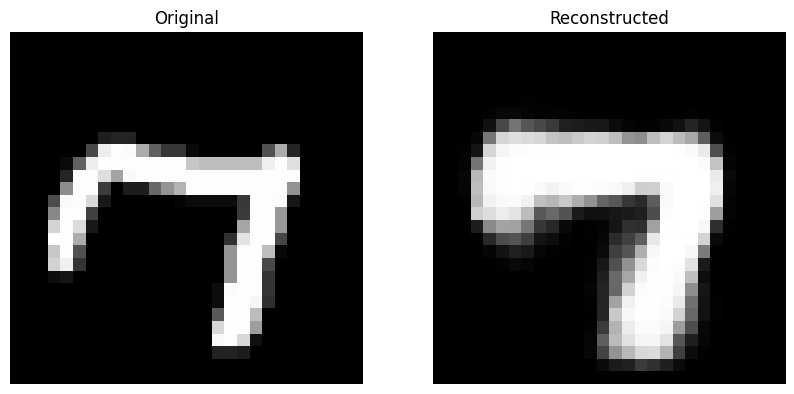

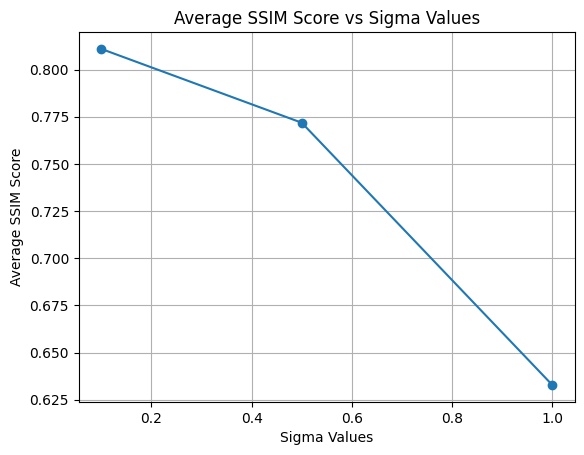

In [13]:
# Train the autoencoder model with noisy images
def train_model_noisy(model, num_epochs, train_loader, optimizer, criterion, sigma):
    print(f'Sigma: {sigma}')
    for epoch in range(num_epochs):
        for batch in train_loader:
            images, _ = batch[0].to(device), batch[1].to(device)
            images = images.view(images.size(0), -1)
            # Add noise to images
            noisy_images = add_noise(images, sigma)
            # Forward pass
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Define sigma values to test
sigma_values = [0.1, 0.5, 1.0]
avg_ssim_scores = []

# Train and evaluate the model for each sigma value
for sigma in sigma_values:
    train_model_noisy(model, num_epochs=10, train_loader=train_loader, optimizer=optimizer, criterion=criterion, sigma=sigma)
    avg_ssim = evaluate_autoencoder(model, test_loader)  # Pass sigma value for evaluation
    avg_ssim_scores.append(avg_ssim)

# Plot the average SSIM test score for each sigma value
plt.plot(sigma_values, avg_ssim_scores, marker='o')
plt.xlabel('Sigma Values')
plt.ylabel('Average SSIM Score')
plt.title('Average SSIM Score vs Sigma Values')
plt.grid(True)
plt.show()
